In [15]:
# Standard Libraries
import os
import time
import random
import glob
from datetime import datetime
from collections import Counter

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Scikit-learn for ML classifiers and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Reproducibility
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)


In [16]:
# Dataset paths
base_dir = "/kaggle/input/coffee-beans-saad"

# Create DataFrame
def create_dataframe(data_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)
    df = pd.DataFrame({"file_path": file_paths, "label": labels}).sample(frac=1).reset_index(drop=True)
    return df

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Label mapping
label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

# Custom Dataset
class CoffeeBeanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        image = Image.open(self.dataframe.iloc[idx]['file_path']).convert("RGB")
        label = label_to_idx[self.dataframe.iloc[idx]['label']]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CoffeeBeanDataset(train_df, transform=train_transforms)
test_dataset = CoffeeBeanDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Linear(256,num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [18]:
num_epochs = 10
train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


Epoch [1/10] Loss: 1.2585 Acc: 0.4408
Epoch [2/10] Loss: 0.8128 Acc: 0.6142
Epoch [3/10] Loss: 0.4922 Acc: 0.8300
Epoch [4/10] Loss: 0.3032 Acc: 0.8958
Epoch [5/10] Loss: 0.2028 Acc: 0.9317
Epoch [6/10] Loss: 0.1267 Acc: 0.9633
Epoch [7/10] Loss: 0.1329 Acc: 0.9542
Epoch [8/10] Loss: 0.0914 Acc: 0.9742
Epoch [9/10] Loss: 0.0843 Acc: 0.9708
Epoch [10/10] Loss: 0.0642 Acc: 0.9817


In [19]:
model.eval()
def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feat = model.features(imgs)
            feat = feat.view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)
print("Feature shape:", X_train.shape)


Feature shape: (1200, 100352)


In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)
start_train = time.time()
rf.fit(X_train, y_train)
end_train = time.time()

start_test = time.time()
y_pred = rf.predict(X_test)
end_test = time.time()

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Training Time: {end_train - start_train:.2f} sec")
print(f"Testing Time: {end_test - start_test:.2f} sec")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", cm)


Training Time: 13.18 sec
Testing Time: 0.03 sec
Accuracy: 0.9925

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.97      1.00      0.99       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Confusion Matrix:
 [[ 97   0   0   3]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]


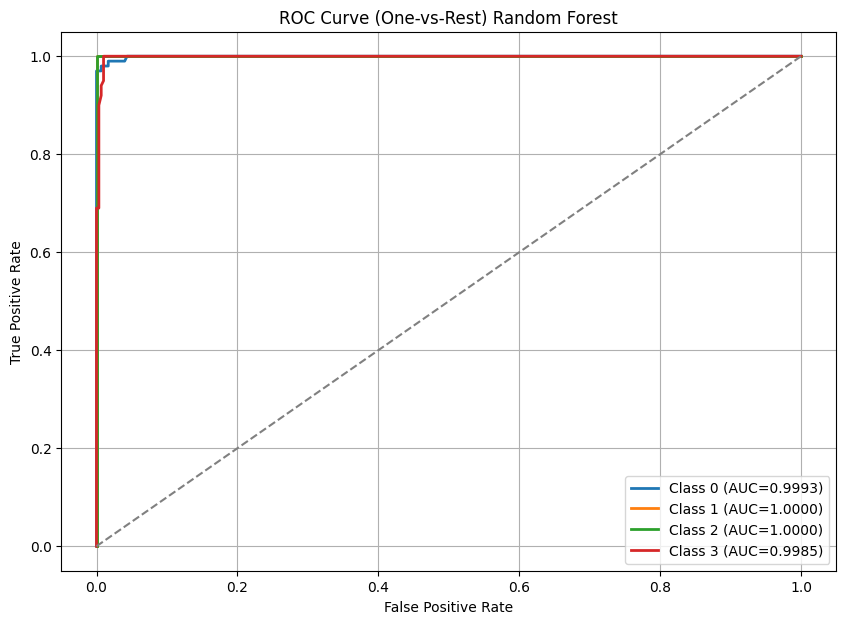

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = rf.predict_proba(X_test)

plt.figure(figsize=(10,7))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


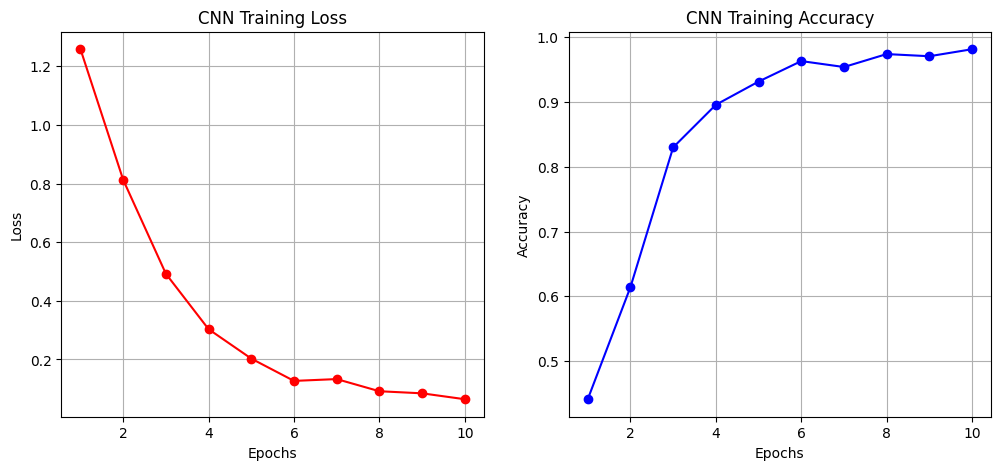

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_loss_history, 'r-o')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("CNN Training Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), train_acc_history, 'b-o')
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("CNN Training Accuracy")
plt.grid(True)
plt.show()
